# Demographics

Demographics of ALL patients in database (regardless of if they have CPVT or not)

- Number of articles
- Number of patients
- Patients by sex
- Patients by variant zygosity
- Number of patients with CPVT phenotype
- Primary diagnosis of patients
- Number of variants (cDNA and protein level)
- Variants by type (missense, deletion, etc)

In [44]:
from typing import Literal

import pandas as pd
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

from analysis.database import get_config

sns.set_style("ticks")

In [45]:
config = get_config()

# create dir for figures
figures_dir = Path(
    os.path.join("..", "figures", config.version_for_dir, "analysis_07"))

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

In [46]:
df = pd.read_excel(
    f"../data/individual_all_data-{config.version}.xlsx",
    index_col=0,
)
df.head()

,individual_id,sex,publication_id,title,first_author,reference,doi,year,publication_database,resource_uri,...,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
0,1,NaN,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,NaN,10.1161/CIRCEP.112.970517,2012,PubMed,https://pubmed.ncbi.nlm.nih.gov/22787013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,female,2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",NaN,10.1016/j.jacc.2011.01.026,2011,PubMed,https://pubmed.ncbi.nlm.nih.gov/21616285,...,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN
2,3,male,3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",NaN,10.1016/j.jacep.2020.03.006,2020,PubMed,https://pubmed.ncbi.nlm.nih.gov/32553227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,female,4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",NaN,10.1253/circj.cj-12-1460,2013,PubMed,https://pubmed.ncbi.nlm.nih.gov/23595086,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,male,5,Gender differences in the inheritance mode of ...,"Ohno, S.",NaN,10.1371/journal.pone.0131517,2015,PubMed,https://pubmed.ncbi.nlm.nih.gov/26114861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
def add_bar_labels(ax, fmt="{:.0f}", ignore_zero=True, direction="vertical"):
    for bar in ax.patches:

        if bar.get_height() == 0 and ignore_zero:
            continue

        if direction == "vertical":
            # Use ax.text() to add text over the bars
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                    fmt.format(bar.get_height()),
                    ha='center', va='bottom')
            # add 1% to the height
            y_min, y_max = ax.get_ylim()
            ax.set_ylim(y_min, (y_max - y_min) * 0.01 + y_max)
        else:
            ax.text(bar.get_width() + 0.02 * bar.get_width(),
                    bar.get_y() + bar.get_height() / 2,
                    fmt.format(bar.get_width()),
                    ha='left', va='center')
            # add 1% to the width
            x_min, x_max = ax.get_xlim()
            ax.set_xlim(x_min, (x_max - x_min) * 0.01 + x_max)


def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir / f"{name}.{fmt}"), dpi=300)

## Num Articles

In [48]:
num_articles = df["publication_id"].nunique()

print(f"Number of articles: {num_articles}")

Number of articles: 221


## Patients

In [49]:
num_patients = df["individual_id"].nunique()

print(f"Number of patients: {num_patients}")

Number of patients: 1342


In [50]:
def add_percent(df_input: pd.DataFrame | pd.Series, denom: Literal[
    "patients", "patient_variants", "variants"] = "patients"):
    if denom == "patients":
        denominator = num_patients
    elif denom == "patient_variants":
        denominator = len(df)
    elif denom == "variants":
        denominator = df["hgvs_string"].nunique()
    else:
        raise ValueError(f"Invalid denominator: {denom}")

    # if it's a series, convert to a dataframe
    if isinstance(df_input, pd.Series):
        df_input = df_input.to_frame()

    total_patients_report = df_input["count"].sum()
    df_input["percentage"] = (
            df_input["count"] / total_patients_report * 100).round(2)

    # get total out of num patients
    print(
        f"Total: {total_patients_report} {total_patients_report / denominator * 100:.2f}%")

    return df_input

In [51]:
add_percent(
    df.drop_duplicates(["individual_id"])["sex"].value_counts(dropna=False))

Total: 1342 100.00%


,count,percentage
sex,,
female,644,47.99
male,527,39.27
NaN,171,12.74


In [52]:
add_percent(
    df.drop_duplicates(["individual_id"])["sex"].value_counts(dropna=True))

Total: 1171 87.26%


,count,percentage
sex,,
female,644,55.0
male,527,45.0


## Patient's Variants

In [53]:
# do not drop duplicates since this sheet is a patient_variant many-many table
add_percent(df["inheritance"].value_counts(), denom="patient_variants")

Total: 350 26.06%


,count,percentage
inheritance,,
inherited,251,71.71
spontaneous,99,28.29


In [54]:
add_percent(df["zygosity"].value_counts(), denom="patient_variants")

Total: 637 47.43%


,count,percentage
zygosity,,
heterozygous,631,99.06
homozygous,6,0.94


# All variant info

In [55]:
num_variants = df["sequence_variant_id"].nunique()

print(f"Number of variants: {num_variants}")

Number of variants: 390


In [56]:
num_variant_by_protein = df["p_hgvs_string"].nunique()

print(f"Number of variants by protein: {num_variant_by_protein}")

Number of variants by protein: 379


In [57]:
# protein change
protein_change_type = df.drop_duplicates(subset=["p_hgvs_string"])[[
    "p_hgvs_string", "protein_change_type"
]].groupby("protein_change_type").count()

total_sum = protein_change_type["p_hgvs_string"].sum()
protein_change_type["percentage"] = (protein_change_type[
                                         "p_hgvs_string"] / total_sum * 100).round(
    2)

protein_change_type

,p_hgvs_string,percentage
protein_change_type,,
Deletion,5,1.32
Frameshift,1,0.26
Insertion,3,0.79
Substitution,370,97.63


In [58]:
# protein change in patients
patient_variant_type = pd.DataFrame(df["protein_change_type"].value_counts())

patient_variant_type["percentage"] = (
        patient_variant_type["count"] / patient_variant_type[
    "count"].sum() * 100).round(2)

patient_variant_type

,count,percentage
protein_change_type,,
Substitution,1277,97.48
Deletion,26,1.98
Insertion,4,0.31
Frameshift,3,0.23


In [59]:
add_percent(df["protein_change_type"].value_counts(), denom="patient_variants")

Total: 1310 97.54%


,count,percentage
protein_change_type,,
Substitution,1277,97.48
Deletion,26,1.98
Insertion,4,0.31
Frameshift,3,0.23


## Primary Diagnosis

Remove patients with primary diagnosis of NaN

In [60]:
df["primary_diagnosis"].value_counts()

primary_diagnosis
Catecholaminergic polymorphic ventricular tachycardia 1                         964
Catecholaminergic polymorphic ventricular tachycardia 1 asymptomatic carrier    132
Substance use disorder                                                           74
Long QT syndrome                                                                 43
Arrhythmogenic right ventricular cardiomyopathy                                  18
Left ventricular non-compaction                                                  18
Short-coupled variant of torsade de pointes                                      15
Sudden infant death syndrome                                                     13
Hyperglycemia                                                                     7
Other                                                                             7
Hypoplastic left heart syndrome                                                   5
Noncompaction cardiomyopathy                              

In [82]:
shorter_names_map = {
    "Catecholaminergic polymorphic ventricular tachycardia 1": "CPVT",
    "Catecholaminergic polymorphic ventricular tachycardia 1 asymptomatic carrier": "CPVT asymptomatic carrier",
    "Long QT syndrome": "Long QT syndrome",
    "Arrhythmogenic right ventricular cardiomyopathy": "ARVD/C",
    "Short-coupled variant of torsade de pointes": "Short-coupled TdP",
    "Left ventricular non-compaction": "LVNC",
    "Sudden infant death syndrome": "SIDS",
}

# anything not in this list will be replaced with "Other"
df_primary = df[['individual_id', 'primary_diagnosis']].dropna()
df_primary["primary_diagnosis"] = df_primary["primary_diagnosis"].apply(
    lambda x: shorter_names_map.get(x, "Other")
)

df_primary_counts = df_primary["primary_diagnosis"].value_counts().reset_index()

df_primary_counts

,primary_diagnosis,count
0,CPVT,964
1,CPVT asymptomatic carrier,132
2,Other,129
3,Long QT syndrome,43
4,LVNC,18
5,ARVD/C,18
6,Short-coupled TdP,15
7,SIDS,13


In [62]:
DEFAULT_COLOR = sns.color_palette("husl", 9)[6]

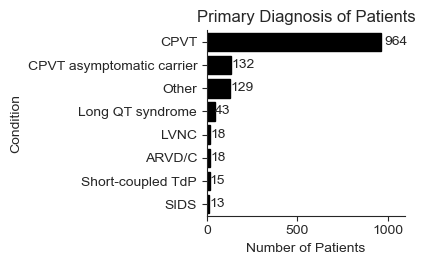

In [85]:
# plt.figure(figsize=(2.125 * 2, 2.75 * 2))
plt.figure(figsize=(4.25, 2.75))
ax = sns.barplot(df_primary_counts, x="count", y="primary_diagnosis",
                 color="black", edgecolor="black",
                 orient="h"
                 )

add_bar_labels(ax, ignore_zero=False, direction="horizontal")

# plt.xticks(rotation=60, ha="center")

sns.despine()
# plt.yticks(fontsize=8)
plt.ylabel("Condition")
plt.xlabel("Number of Patients")
plt.title("Primary Diagnosis of Patients")

plt.tight_layout()

save_current_plot("primary_diagnosis")

plt.show()